# Training the model with the loaded data.

In [8]:
import os, itertools, random, imageio, sklearn
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

In [9]:
faces_folder = "faces"
pickle_file = "faces.pickle"
trained_models_folder = "./tf_trained/"

pixel_depth = 255.0
image_size = 128
num_labels = 2
input_size = image_size * image_size * 2

In [10]:
n_bytes = 2**31
max_bytes = 2**31 - 1
bytes_in = bytearray(0)

pickle_file_size = os.path.getsize(pickle_file)
with open(pickle_file, 'rb') as f_in:
  for _ in range(0, pickle_file_size, max_bytes):
    bytes_in += f_in.read(max_bytes)
save = pickle.loads(bytes_in)

train_dataset = save['train_dataset']
train_labels = save['train_labels']
valid_dataset = save['valid_dataset']
valid_labels = save['valid_labels']
test_dataset = save['test_dataset']
test_labels = save['test_labels']
del save  # hint to help gc free up memory

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (23014, 32768) (23014, 2)
Validation set (1275, 32768) (1275, 2)
Test set (1275, 32768) (1275, 2)


In [11]:
# shuffleing the data
train_dataset, train_labels = sklearn.utils.shuffle(train_dataset, train_labels)
valid_dataset, valid_labels = sklearn.utils.shuffle(valid_dataset, valid_labels)
test_dataset, test_labels = sklearn.utils.shuffle(test_dataset, test_labels)
print("done shuffle")

done shuffle


In [12]:
def accuracy(predictions, labels):
  compare_elements = np.argmax(predictions, 1) == np.argmax(labels, 1)
  return (100.0 * np.sum(compare_elements) / predictions.shape[0])

def makedir(path):
  if not os.path.exists(path):
    os.makedirs(path)
    
def accuracy_averaged(steps, accuracy_over_time, every_index=10):
  new_accuracy = np.mean(np.array(accuracy_over_time).reshape(-1, every_index), axis=1)
  new_steps = steps[0::every_index]
  return new_steps, new_accuracy

### 1 hidden layer L2 optimization

In [ ]:
batch_size = 128
learning_rate = 0.4
l2_reg_beta = 0.001
num_steps = 20001

graph = tf.Graph()
with graph.as_default():
  
  # input data
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size * 2))
  tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, 2))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset  = tf.constant(test_dataset)
  
  # hidden nodes
  hidden_nodes = 1024
  hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size * 2, hidden_nodes]))
  hidden_biases = tf.Variable(tf.zeros([hidden_nodes]))
  hidden_comp = tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases
  hidden_layer = tf.nn.relu(hidden_comp)
  
  # variables
  weights = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # training
  logits = tf.matmul(hidden_layer, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))
  loss += (l2_reg_beta * tf.nn.l2_loss(hidden_weights) + l2_reg_beta * tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
  # valid prediction
  valid_relu = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_relu, weights) + biases)
  
  # test prediction
  test_relu = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
  test_prediction  = tf.nn.softmax(tf.matmul(test_relu, weights) + biases)
  
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized\n")
  
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%\n" % accuracy(
        valid_prediction.eval(), valid_labels))
      
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
### 3 hidden layer and with L2 optimization

Initialized

Minibatch loss at step 0: 3.463964
Minibatch accuracy: 51.6%
Validation accuracy: 47.1%

Minibatch loss at step 250: 3.162962
Minibatch accuracy: 67.2%
Validation accuracy: 58.0%

Minibatch loss at step 500: 2.870050
Minibatch accuracy: 75.0%
Validation accuracy: 74.3%

Minibatch loss at step 750: 2.629769
Minibatch accuracy: 74.2%
Validation accuracy: 77.7%

Minibatch loss at step 1000: 2.370912
Minibatch accuracy: 79.7%
Validation accuracy: 78.1%

Minibatch loss at step 1250: 2.127718
Minibatch accuracy: 84.4%
Validation accuracy: 84.3%

Minibatch loss at step 1500: 1.991231
Minibatch accuracy: 82.8%
Validation accuracy: 81.6%

Minibatch loss at step 1750: 1.804081
Minibatch accuracy: 87.5%
Validation accuracy: 85.6%

Minibatch loss at step 2000: 1.700452
Minibatch accuracy: 80.5%
Validation accuracy: 76.1%

Minibatch loss at step 2250: 1.536572
Minibatch accuracy: 85.2%
Validation accuracy: 86.7%

Minibatch loss at step 2500: 1.403520
Minibatch accuracy: 89.1%
Validatio

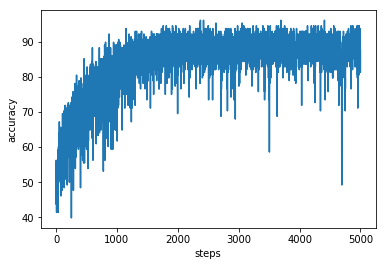

In [27]:
model_name = "3HiddenL2Optimization"

batch_size = 128
num_steps = 5000
report_every = 250
starting_learning_rate = 0.2

hidden_layer_1_size = 2048
hidden_layer_2_size = 1024
hidden_layer_3_size = 512

hidden_layer_1_stddev = np.sqrt(2.0 / input_size) 
hidden_layer_2_stddev = np.sqrt(2.0 / hidden_layer_1_size)
hidden_layer_3_stddev = np.sqrt(2.0 / hidden_layer_2_size)
output_layer_stddev = np.sqrt(2.0 / hidden_layer_3_size)

hidden_layer_1_keep_prob = 0.5
hidden_layer_2_keep_prob = 0.7
hidden_layer_3_keep_prob = 0.8

beta_1 = 0.001
beta_2 = 0.001
beta_3 = 0.001
beta_4 = 0.001

graph = tf.Graph()
with graph.as_default():
  
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # first hidden layer
  hidden_layer_1_weights = tf.Variable(tf.truncated_normal(
    [input_size, hidden_layer_1_size], stddev=hidden_layer_1_stddev))
  hidden_layer_1_biases = tf.Variable(tf.zeros([hidden_layer_1_size]))
  hidden_layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_layer_1_weights) + hidden_layer_1_biases)
  
  # second hidden layer
  hidden_layer_2_weights = tf.Variable(tf.truncated_normal(
    [hidden_layer_1_size, hidden_layer_2_size], stddev=hidden_layer_2_stddev))
  hidden_layer_2_biases = tf.Variable(tf.zeros([hidden_layer_2_size]))
  hidden_layer_2 = tf.nn.relu(tf.matmul(hidden_layer_1, hidden_layer_2_weights) + hidden_layer_2_biases)
  
  # third hidden layer
  hidden_layer_3_weights = tf.Variable(tf.truncated_normal(
    [hidden_layer_2_size, hidden_layer_3_size], stddev=hidden_layer_3_stddev))
  hidden_layer_3_biases = tf.Variable(tf.zeros([hidden_layer_3_size]))
  hidden_layer_3 = tf.nn.relu(tf.matmul(hidden_layer_2, hidden_layer_3_weights) + hidden_layer_3_biases)
  
  # output layer
  output_weights = tf.Variable(tf.truncated_normal(
    [hidden_layer_3_size, num_labels], stddev=output_layer_stddev))
  output_biases = tf.Variable(tf.zeros([num_labels]))
  logits = tf.matmul(hidden_layer_3, output_weights) + output_biases

  # calculate the loss with regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf_train_labels))
  loss += (beta_1 * tf.nn.l2_loss(hidden_layer_1_weights) +
           beta_2 * tf.nn.l2_loss(hidden_layer_2_weights) +
           beta_3 * tf.nn.l2_loss(hidden_layer_3_weights) +
           beta_4 * tf.nn.l2_loss(output_weights))
  
  # learn with exponential rate decay.
  global_step = tf.Variable(0, trainable=False)
  learning_rate = tf.train.exponential_decay(starting_learning_rate, global_step, 100000, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # train prediction
  train_prediction = tf.nn.softmax(logits)

  # setup validation prediction step.
  validation_hidden_layer_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_layer_1_weights) + hidden_layer_1_biases)
  validation_hidden_layer_2 = tf.nn.relu(tf.matmul(validation_hidden_layer_1, hidden_layer_2_weights) + hidden_layer_2_biases)
  validation_hidden_layer_3 = tf.nn.relu(tf.matmul(validation_hidden_layer_2, hidden_layer_3_weights) + hidden_layer_3_biases)
  validation_logits = tf.matmul(validation_hidden_layer_3, output_weights) + output_biases
  validation_prediction = tf.nn.softmax(validation_logits)

  # and setup the test prediction step.  
  test_hidden_layer_1 = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_layer_1_weights) + hidden_layer_1_biases)
  test_hidden_layer_2 = tf.nn.relu(tf.matmul(test_hidden_layer_1, hidden_layer_2_weights) + hidden_layer_2_biases)
  test_hidden_layer_3 = tf.nn.relu(tf.matmul(test_hidden_layer_2, hidden_layer_3_weights) + hidden_layer_3_biases)
  test_logits = tf.matmul(test_hidden_layer_3, output_weights) + output_biases
  test_prediction = tf.nn.softmax(test_logits)
  
  saver = tf.train.Saver()

accuracy_over_time = []
steps = []
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized\n")

  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_over_time.append(accuracy(predictions, batch_labels))
    steps.append(step)
    
    if (step % report_every == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%\n" % accuracy(validation_prediction.eval(), valid_labels))
  
  print("  Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  steps, accuracy_over_time = accuracy_averaged(steps, accuracy_over_time)
  plt.plot(steps, accuracy_over_time)
  plt.xlabel("steps")
  plt.ylabel("accuracy")
  plt.show()

  # Save the final model
  model_folder = trained_models_folder + model_name
  makedir(model_folder)
  saver.save(session, model_folder + "/" + model_name)

---
### 3 hidden layers with dropout and L2 optimization

Initialized

Minibatch loss at step 0: 1.741124
Minibatch accuracy: 48.4%
Validation accuracy: 50.8%

Minibatch loss at step 250: 1.625282
Minibatch accuracy: 39.8%
Validation accuracy: 53.7%

Minibatch loss at step 500: 1.523569
Minibatch accuracy: 47.7%
Validation accuracy: 54.9%

Minibatch loss at step 750: 1.438215
Minibatch accuracy: 56.2%
Validation accuracy: 54.9%

Minibatch loss at step 1000: 1.355699
Minibatch accuracy: 61.7%
Validation accuracy: 56.5%

Minibatch loss at step 1250: 1.286745
Minibatch accuracy: 62.5%
Validation accuracy: 57.2%

Minibatch loss at step 1500: 1.237225
Minibatch accuracy: 52.3%
Validation accuracy: 55.3%

Minibatch loss at step 1750: 1.176625
Minibatch accuracy: 60.2%
Validation accuracy: 58.2%

Minibatch loss at step 2000: 1.155388
Minibatch accuracy: 60.2%
Validation accuracy: 57.7%

Minibatch loss at step 2250: 1.055303
Minibatch accuracy: 62.5%
Validation accuracy: 60.5%

Minibatch loss at step 2500: 1.020376
Minibatch accuracy: 60.9%
Validatio

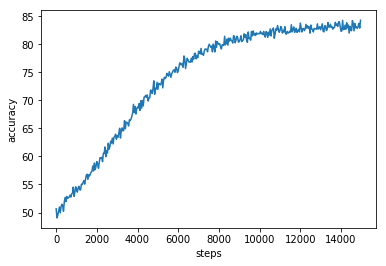

In [7]:
model_name = "3HiddenDropoutAndL2Optimization"

batch_size = 128
num_steps = 15000
report_every = 250
starting_learning_rate = 0.2

layer_sizes = {
  "1": 1024,
  "2": 256,
  "3": 32
}

stddevs = {
  "1": np.sqrt(2.0 / input_size) ,
  "2": np.sqrt(2.0 / layer_sizes["1"]),
  "3": np.sqrt(2.0 / layer_sizes["2"]),
  "out": np.sqrt(2.0 / layer_sizes["3"]),
}

keep_probs = {
  "1": 0.4,
  "2": 0.6,
  "3": 0.8,
}

betas = {
  "1": 0.001,
  "2": 0.001,
  "3": 0.001,
  "4": 0.001,
}

weights = {}
biases = {}
layers = {}

graph = tf.Graph()
with graph.as_default():
  
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # first hidden layer
  weights["1"] = tf.Variable(tf.truncated_normal(
    [input_size, layer_sizes["1"]], stddev=stddevs["1"]))
  biases["1"] = tf.Variable(tf.zeros([layer_sizes["1"]]))
  layers["1"] = tf.nn.dropout(
    tf.nn.relu(tf.matmul(tf_train_dataset, weights["1"]) + biases["1"]),
    keep_probs["1"])
  
  # second hidden layer
  weights["2"] = tf.Variable(tf.truncated_normal(
    [layer_sizes["1"], layer_sizes["2"]], stddev=stddevs["2"]))
  biases["2"] = tf.Variable(tf.zeros([layer_sizes["2"]]))
  layers["2"] = tf.nn.dropout(
    tf.nn.relu(tf.matmul(layers["1"], weights["2"]) + biases["2"]),
    keep_probs["2"])
  
  # third hidden layer
  weights["3"] = tf.Variable(tf.truncated_normal(
    [layer_sizes["2"], layer_sizes["3"]], stddev=stddevs["3"]))
  biases["3"] = tf.Variable(tf.zeros([layer_sizes["3"]]))
  layers["3"] = tf.nn.dropout(
    tf.nn.relu(tf.matmul(layers["2"], weights["3"]) + biases["3"]), 
    keep_probs["3"])
  
  # output layer
  weights["out"] = tf.Variable(tf.truncated_normal(
    [layer_sizes["3"], num_labels], stddev=stddevs["out"]))
  biases["out"] = tf.Variable(tf.zeros([num_labels]))
  
  # logit layer
  logits = tf.matmul(layers["3"], weights["out"]) + biases["out"]

  # calculate the loss with regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf_train_labels))
  loss += (betas["1"] * tf.nn.l2_loss(weights["1"]) +
           betas["2"] * tf.nn.l2_loss(weights["2"]) +
           betas["3"] * tf.nn.l2_loss(weights["3"]) +
           betas["4"] * tf.nn.l2_loss(weights["out"]))
  
  # learn with exponential rate decay.
  global_step = tf.Variable(0, trainable=False)
  learning_rate = tf.train.exponential_decay(starting_learning_rate, global_step, 100000, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # train prediction
  train_prediction = tf.nn.softmax(logits)

  # setup validation prediction step.
  validation_layers = {}
  validation_layers["1"] = tf.nn.relu(tf.matmul(tf_valid_dataset, weights["1"]) + biases["1"])
  validation_layers["2"] = tf.nn.relu(tf.matmul(validation_layers["1"], weights["2"]) + biases["2"])
  validation_layers["3"] = tf.nn.relu(tf.matmul(validation_layers["2"], weights["3"]) + biases["3"])
  validation_logits = tf.matmul(validation_layers["3"], weights["out"]) + biases["out"]
  validation_prediction = tf.nn.softmax(validation_logits)

  # and setup the test prediction step.  
  test_layers = {}
  test_layers["1"] = tf.nn.relu(tf.matmul(tf_test_dataset, weights["1"]) + biases["1"])
  test_layers["2"] = tf.nn.relu(tf.matmul(test_layers["1"], weights["2"]) + biases["2"])
  test_layers["3"] = tf.nn.relu(tf.matmul(test_layers["2"], weights["3"]) + biases["3"])
  test_logits = tf.matmul(test_layers["3"], weights["out"]) + biases["out"]
  test_prediction = tf.nn.softmax(test_logits)
  
  saver = tf.train.Saver()

accuracy_over_time = []
steps = []
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized\n")

  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_over_time.append(accuracy(predictions, batch_labels))
    steps.append(step)
    
    if (step % report_every == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%\n" % accuracy(validation_prediction.eval(), valid_labels))
  
  print("  Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  steps, accuracy_over_time = accuracy_averaged(steps, accuracy_over_time, 40)
  plt.plot(steps, accuracy_over_time)
  plt.xlabel("steps")
  plt.ylabel("accuracy")
  plt.show()

  # Save the final model
  model_folder = trained_models_folder + model_name
  makedir(model_folder)
  saver.save(session, model_folder + "/" + model_name)

---
### 3 Hidden Layers with Dropout no L2

Initialized

Minibatch loss at step 0: 0.750843
Minibatch accuracy: 52.3%
Validation accuracy: 48.9%

Minibatch loss at step 250: 0.683756
Minibatch accuracy: 62.5%
Validation accuracy: 56.2%

Minibatch loss at step 500: 0.695410
Minibatch accuracy: 53.1%
Validation accuracy: 55.0%

Minibatch loss at step 750: 0.677178
Minibatch accuracy: 53.9%
Validation accuracy: 57.3%

Minibatch loss at step 1000: 0.693074
Minibatch accuracy: 56.2%
Validation accuracy: 58.3%

Minibatch loss at step 1250: 0.667060
Minibatch accuracy: 54.7%
Validation accuracy: 58.7%

Minibatch loss at step 1500: 0.648692
Minibatch accuracy: 57.8%
Validation accuracy: 62.0%

Minibatch loss at step 1750: 0.655185
Minibatch accuracy: 54.7%
Validation accuracy: 60.1%

Minibatch loss at step 2000: 0.634161
Minibatch accuracy: 64.1%
Validation accuracy: 62.6%

Minibatch loss at step 2250: 0.579588
Minibatch accuracy: 63.3%
Validation accuracy: 63.7%

Minibatch loss at step 2500: 0.626193
Minibatch accuracy: 61.7%
Validatio

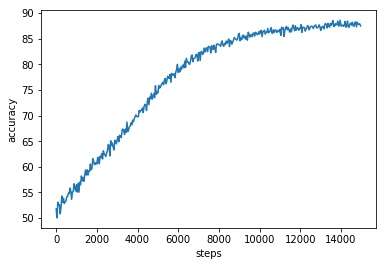

In [15]:
model_name = "3HiddenWithDropout"

batch_size = 128
num_steps = 15000
report_every = 250
starting_learning_rate = 0.2

layer_sizes = {
  "1": 2048,
  "2": 1024,
  "3": 64
}

stddevs = {
  "1": np.sqrt(2.0 / input_size) ,
  "2": np.sqrt(2.0 / layer_sizes["1"]),
  "3": np.sqrt(2.0 / layer_sizes["2"]),
  "out": np.sqrt(2.0 / layer_sizes["3"]),
}

keep_probs = {
  "1": 0.4,
  "2": 0.6,
  "3": 0.8,
}

betas = {
  "1": 0.001,
  "2": 0.001,
  "3": 0.001,
  "4": 0.001,
}

weights = {}
biases = {}
layers = {}

graph = tf.Graph()
with graph.as_default():
  
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size), name="dataset")
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name="labels")
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # first hidden layer
  weights["1"] = tf.Variable(tf.truncated_normal(
    [input_size, layer_sizes["1"]], stddev=stddevs["1"]), name="weights_1")
  biases["1"] = tf.Variable(tf.zeros([layer_sizes["1"]]), name="biases_1")
  layers["1"] = tf.nn.dropout(
    tf.nn.relu(tf.matmul(tf_train_dataset, weights["1"]) + biases["1"]),
    keep_probs["1"])
  
  # second hidden layer
  weights["2"] = tf.Variable(tf.truncated_normal(
    [layer_sizes["1"], layer_sizes["2"]], stddev=stddevs["2"]), name="weights_2")
  biases["2"] = tf.Variable(tf.zeros([layer_sizes["2"]]), name="biases_2")
  layers["2"] = tf.nn.dropout(
    tf.nn.relu(tf.matmul(layers["1"], weights["2"]) + biases["2"]),
    keep_probs["2"])
  
  # third hidden layer
  weights["3"] = tf.Variable(tf.truncated_normal(
    [layer_sizes["2"], layer_sizes["3"]], stddev=stddevs["3"]), name="weights_3")
  biases["3"] = tf.Variable(tf.zeros([layer_sizes["3"]]), name="biases_3")
  layers["3"] = tf.nn.dropout(
    tf.nn.relu(tf.matmul(layers["2"], weights["3"]) + biases["3"]), 
    keep_probs["3"])
  
  # output layer
  weights["out"] = tf.Variable(tf.truncated_normal(
    [layer_sizes["3"], num_labels], stddev=stddevs["out"]), name="weights_out")
  biases["out"] = tf.Variable(tf.zeros([num_labels]), name="biases_out")
  
  # logit layer
  logits = tf.matmul(layers["3"], weights["out"]) + biases["out"]

  # calculate the loss with regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf_train_labels), name="loss")
  
  # learn with exponential rate decay.
  global_step = tf.Variable(0, trainable=False)
  learning_rate = tf.train.exponential_decay(starting_learning_rate, global_step, 100000, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # train prediction
  train_prediction = tf.nn.softmax(logits)

  # setup validation prediction step.
  validation_layers = {}
  validation_layers["1"] = tf.nn.relu(tf.matmul(tf_valid_dataset, weights["1"]) + biases["1"])
  validation_layers["2"] = tf.nn.relu(tf.matmul(validation_layers["1"], weights["2"]) + biases["2"])
  validation_layers["3"] = tf.nn.relu(tf.matmul(validation_layers["2"], weights["3"]) + biases["3"])
  validation_logits = tf.matmul(validation_layers["3"], weights["out"]) + biases["out"]
  validation_prediction = tf.nn.softmax(validation_logits)

  # and setup the test prediction step.  
  test_layers = {}
  test_layers["1"] = tf.nn.relu(tf.matmul(tf_test_dataset, weights["1"]) + biases["1"])
  test_layers["2"] = tf.nn.relu(tf.matmul(test_layers["1"], weights["2"]) + biases["2"])
  test_layers["3"] = tf.nn.relu(tf.matmul(test_layers["2"], weights["3"]) + biases["3"])
  test_logits = tf.matmul(test_layers["3"], weights["out"]) + biases["out"]
  test_prediction = tf.nn.softmax(test_logits)
  
  saver = tf.train.Saver()

accuracy_over_time = []
steps = []
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized\n")

  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_over_time.append(accuracy(predictions, batch_labels))
    steps.append(step)
    
    if (step % report_every == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%\n" % accuracy(validation_prediction.eval(), valid_labels))
  
  print("  Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  steps, accuracy_over_time = accuracy_averaged(steps, accuracy_over_time, 40)
  plt.plot(steps, accuracy_over_time)
  plt.xlabel("steps")
  plt.ylabel("accuracy")
  plt.show()

  # Save the final model
  model_folder = trained_models_folder + model_name
  makedir(model_folder)
  saver.save(session, model_folder + "/" + model_name)

---
### 4 Hidden Layers with Dropout

Initialized

Minibatch loss at step 0: 0.790982
Minibatch accuracy: 47.7%
Validation accuracy: 48.7%

Minibatch loss at step 250: 0.697695
Minibatch accuracy: 43.8%
Validation accuracy: 49.3%

Minibatch loss at step 500: 0.697990
Minibatch accuracy: 47.7%
Validation accuracy: 49.3%

Minibatch loss at step 750: 0.693416
Minibatch accuracy: 49.2%
Validation accuracy: 52.5%

Minibatch loss at step 1000: 0.702568
Minibatch accuracy: 50.0%
Validation accuracy: 53.3%

Minibatch loss at step 1250: 0.692605
Minibatch accuracy: 50.8%
Validation accuracy: 49.3%

Minibatch loss at step 1500: 0.698549
Minibatch accuracy: 53.1%
Validation accuracy: 49.1%

Minibatch loss at step 1750: 0.688049
Minibatch accuracy: 52.3%
Validation accuracy: 54.5%

Minibatch loss at step 2000: 0.695839
Minibatch accuracy: 49.2%
Validation accuracy: 54.3%

Minibatch loss at step 2250: 0.683118
Minibatch accuracy: 47.7%
Validation accuracy: 55.1%

Minibatch loss at step 2500: 0.693345
Minibatch accuracy: 50.0%
Validatio

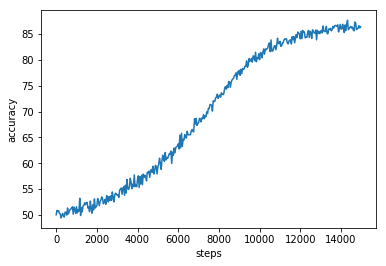

In [16]:
model_name = "4HiddenWithDropout"

batch_size = 128
num_steps = 15000
report_every = 250
starting_learning_rate = 0.2

layer_sizes = {
  "1": 2048,
  "2": 1024,
  "3": 512,
  "4": 64
}

stddevs = {
  "1": np.sqrt(2.0 / input_size) ,
  "2": np.sqrt(2.0 / layer_sizes["1"]),
  "3": np.sqrt(2.0 / layer_sizes["2"]),
  "4": np.sqrt(2.0 / layer_sizes["3"]),
  "out": np.sqrt(2.0 / layer_sizes["4"]),
}

keep_probs = {
  "1": 0.5,
  "2": 0.5,
  "3": 0.5,
  "4": 0.5
}

weights = {}
biases = {}
layers = {}

graph = tf.Graph()
with graph.as_default():
  
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size), name="dataset")
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name="labels")
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # first hidden layer
  weights["1"] = tf.Variable(tf.truncated_normal(
    [input_size, layer_sizes["1"]], stddev=stddevs["1"]), name="weights_1")
  biases["1"] = tf.Variable(tf.zeros([layer_sizes["1"]]), name="biases_1")
  layers["1"] = tf.nn.dropout(
    tf.nn.relu(tf.matmul(tf_train_dataset, weights["1"]) + biases["1"]),
    keep_probs["1"])
  
  # second hidden layer
  weights["2"] = tf.Variable(tf.truncated_normal(
    [layer_sizes["1"], layer_sizes["2"]], stddev=stddevs["2"]), name="weights_2")
  biases["2"] = tf.Variable(tf.zeros([layer_sizes["2"]]), name="biases_2")
  layers["2"] = tf.nn.dropout(
    tf.nn.relu(tf.matmul(layers["1"], weights["2"]) + biases["2"]),
    keep_probs["2"])
  
  # third hidden layer
  weights["3"] = tf.Variable(tf.truncated_normal(
    [layer_sizes["2"], layer_sizes["3"]], stddev=stddevs["3"]), name="weights_3")
  biases["3"] = tf.Variable(tf.zeros([layer_sizes["3"]]), name="biases_3")
  layers["3"] = tf.nn.dropout(
    tf.nn.relu(tf.matmul(layers["2"], weights["3"]) + biases["3"]), 
    keep_probs["3"])
  
  # fourth hidden layer
  weights["4"] = tf.Variable(tf.truncated_normal(
    [layer_sizes["3"], layer_sizes["4"]], stddev=stddevs["4"]), name="weights_4")
  biases["4"] = tf.Variable(tf.zeros([layer_sizes["4"]]), name="biases_4")
  layers["4"] = tf.nn.dropout(
    tf.nn.relu(tf.matmul(layers["3"], weights["4"]) + biases["4"]), 
    keep_probs["4"])
  
  # output layer
  weights["out"] = tf.Variable(tf.truncated_normal(
    [layer_sizes["4"], num_labels], stddev=stddevs["out"]), name="weights_out")
  biases["out"] = tf.Variable(tf.zeros([num_labels]), name="biases_out")
  
  # logit layer
  logits = tf.matmul(layers["4"], weights["out"]) + biases["out"]

  # calculate the loss with regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf_train_labels), name="loss")
  
  # learn with exponential rate decay.
  global_step = tf.Variable(0, trainable=False)
  learning_rate = tf.train.exponential_decay(starting_learning_rate, global_step, 100000, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # train prediction
  train_prediction = tf.nn.softmax(logits)

  # setup validation prediction step.
  validation_layers = {}
  validation_layers["1"] = tf.nn.relu(tf.matmul(tf_valid_dataset, weights["1"]) + biases["1"])
  validation_layers["2"] = tf.nn.relu(tf.matmul(validation_layers["1"], weights["2"]) + biases["2"])
  validation_layers["3"] = tf.nn.relu(tf.matmul(validation_layers["2"], weights["3"]) + biases["3"])
  validation_layers["4"] = tf.nn.relu(tf.matmul(validation_layers["3"], weights["4"]) + biases["4"])
  validation_logits = tf.matmul(validation_layers["4"], weights["out"]) + biases["out"]
  validation_prediction = tf.nn.softmax(validation_logits)

  # and setup the test prediction step.  
  test_layers = {}
  test_layers["1"] = tf.nn.relu(tf.matmul(tf_test_dataset, weights["1"]) + biases["1"])
  test_layers["2"] = tf.nn.relu(tf.matmul(test_layers["1"], weights["2"]) + biases["2"])
  test_layers["3"] = tf.nn.relu(tf.matmul(test_layers["2"], weights["3"]) + biases["3"])
  test_layers["4"] = tf.nn.relu(tf.matmul(test_layers["3"], weights["4"]) + biases["4"])
  test_logits = tf.matmul(test_layers["4"], weights["out"]) + biases["out"]
  test_prediction = tf.nn.softmax(test_logits)
  
  saver = tf.train.Saver()

accuracy_over_time = []
steps = []
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized\n")

  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_over_time.append(accuracy(predictions, batch_labels))
    steps.append(step)
    
    if (step % report_every == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%\n" % accuracy(validation_prediction.eval(), valid_labels))
  
  print("  Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  steps, accuracy_over_time = accuracy_averaged(steps, accuracy_over_time, 40)
  plt.plot(steps, accuracy_over_time)
  plt.xlabel("steps")
  plt.ylabel("accuracy")
  plt.show()

  # Save the final model
  model_folder = trained_models_folder + model_name
  makedir(model_folder)
  saver.save(session, model_folder + "/" + model_name)